## 51단계: MNIST 학습

> 간단히 복습하면, 우선 Dataset 클래스로 데이터셋 처리를 위한 공통 인터페이스를 마련했고, '전처리'를 설정할 수 있도록 했습니다. 그리고 DataLoader 클래스로는 Dataset에서 미니배치 단위로 데이터를 꺼낼 수 있게 했습니다. 이상의 관계를 `그림 51-1`로 표현할 수 있습니다. \
이번 단계에서는 이상의 데이터셋 구조를 활용하여 MNIST 데이터셋을 학습할 것입니다.

<img src="images/그림 51-1.png" width=400/>

### 51.1 MNIST 데이터셋

len(train_set) 60000
len(test_set) 10000
type(x), x.shape <class 'numpy.ndarray'> (1, 28, 28)
label 5


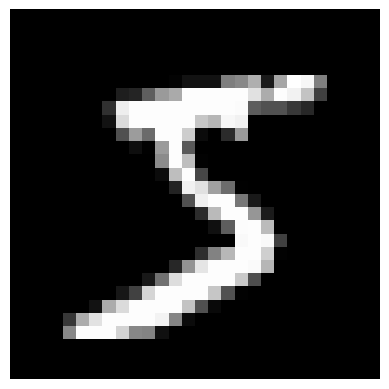

In [1]:
import matplotlib.pyplot as plt
import dezero

train_set = dezero.datasets.MNIST(train=True, transform=None)
test_set = dezero.datasets.MNIST(train=False, transform=None)

print("len(train_set)", len(train_set))
print("len(test_set)", len(test_set))

x, t = train_set[0]
print("type(x), x.shape", type(x), x.shape)
print("label", t)

plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

In [2]:
# 전처리 추가
import numpy as np

def f(x):
    x = x.flatten()
    x = x.astype(np.float32)
    x /= 255.0
    return x

train_set = dezero.datasets.MNIST(train=True, transform=f)
test_set = dezero.datasets.MNIST(train=False, transform=f)

# 다만, MNIST 클래스 내부에 transform을 정의해뒀기 때문에
# transform 인자를 지정하지 않으면 자동으로 전처리가 적용된다.

### 51.2 MNIST 학습하기

In [3]:
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP


max_epoch = 5
batch_size = 100
hidden_size = 1000

train_set = dezero.datasets.MNIST(train=True)
test_set = dezero.datasets.MNIST(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 10))
optimizer = optimizers.SGD().setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad():
        for x, t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)))

epoch: 1
train loss: 1.9097, accuracy: 0.5569
test loss: 1.5337, accuracy: 0.7324
epoch: 2
train loss: 1.2796, accuracy: 0.7728
test loss: 1.0368, accuracy: 0.8102
epoch: 3
train loss: 0.9212, accuracy: 0.8186
test loss: 0.7898, accuracy: 0.8445
epoch: 4
train loss: 0.7376, accuracy: 0.8411
test loss: 0.6551, accuracy: 0.8556
epoch: 5
train loss: 0.6336, accuracy: 0.8545
test loss: 0.5743, accuracy: 0.8680


### 51.3 모델 개선하기

ReLU를 사용해보자.

<img src="images/식 51.3.png" width=400/>

In [4]:
# dezero/functions.py

from dezero import Function

class ReLU(Function):
    def forward(self, x):
        y = np.maximum(x, 0.0)  # x의 각 원소와 0.0 중 큰 값을 반환
        return y

    def backward(self, gy):
        x, = self.inputs
        mask = x.data > 0  # 출력 쪽 기울기를 '통과시킬지' 표시
        gx = gy * mask  # mask와 기울기를 곱해줌
        return gx


In [5]:
max_epoch = 5
batch_size = 100
hidden_size = 1000

train_set = dezero.datasets.MNIST(train=True)
test_set = dezero.datasets.MNIST(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

# model = MLP((hidden_size, 10))
# optimizer = optimizers.SGD().setup(model)
model = MLP((hidden_size, hidden_size, 10), activation=F.relu)
optimizer = optimizers.Adam().setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad():
        for x, t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)))

epoch: 1
train loss: 0.1912, accuracy: 0.9421
test loss: 0.1056, accuracy: 0.9661
epoch: 2
train loss: 0.0739, accuracy: 0.9766
test loss: 0.0875, accuracy: 0.9728
epoch: 3
train loss: 0.0493, accuracy: 0.9840
test loss: 0.0953, accuracy: 0.9710
epoch: 4
train loss: 0.0349, accuracy: 0.9888
test loss: 0.0701, accuracy: 0.9788
epoch: 5
train loss: 0.0293, accuracy: 0.9906
test loss: 0.0717, accuracy: 0.9804
